# WATER BAG CLASSIFICATION - IMBALANCE AND CALIBRATION
### BASED ON INMET METHEOROLOGICAL STATIONS DATA

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [2]:
import os, json, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time serie features transformation pipeline & binary classification pipeline (Authoral)
from Modulos.sample_filter import min_max_filter_stats, min_max_filter
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample
from Modulos.imbalanced_classification import ClassificationPipeline, classesGroupRecall

#### Preprocessing & machine learning modules
from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt
from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr
from imblearn import ensemble

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

# Select specific classification models
gbc = classifiers['GradientBoostingClassifier']
brfc = ensemble.BalancedRandomForestClassifier

#### Define metrics and scoring functions
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall', 'precision': 'precision',
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1
}

c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


### Custom functions

In [3]:
from imblearn.under_sampling import RandomUnderSampler

def balanced_filtered_test_cv(X, Y, X_filt, cv_filt, seed=None, test_prct='natural'):

    X_index = np.array(range(X.shape[0]))
    out_index = X_index[~X.index.isin(X_filt.index)].tolist() # filtered out records index, only contains negative class samples

    if test_prct == 'Y':
        y_cnt = Y.value_counts(); test_prct = y_cnt[1] / y_cnt[0]
    rus = RandomUnderSampler(test_prct, random_state=seed)

    # Reuse group shuffle and include left out negative class test samples 
    cv_plus = []
    for t_idx, e_idx in cv_filt:
        t_idx_x,  e_idx_x = (X_index[X.index.isin(X_filt.iloc[idx].index)].tolist() for idx in [t_idx, e_idx]) # Convert X_filt positional index to X positional index
        left_test = e_idx_x + out_index
        x_test, y_test = Xf.iloc[left_test], Y.iloc[left_test]
        x_under, y_under = rus.fit_resample(x_test, y_test)
        y_under.index = y_test.index[rus.sample_indices_]
        left_under = X_index[X.index.isin(y_under.index)].tolist()
        cv_plus.append((t_idx_x, left_under)) 
    print_cls_cnt(Y, cv_plus[0][0], cv_plus[0][1])
    return cv_plus

---
## Load & Preprocess Data

In [4]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True)

data = project.data
group_ts = project.time_serie
waterbags = project.waterbags

# Drop records before july, 2018 to reduce imbalance
data = data['2018-06':]
group_ts = group_ts['2018-06':]

# Sample groups names per group label
routes = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

---

# Preprocessing and Data Transformation

### Feature dataset and target variables

In [5]:
top_grp = '1'

X = TimeseriesTransformPipeline(
    data, cut=-1,
    drop_empty_cols=True, scale=True,
    interpolate=None, fillna=None
)

Xf = TimeseriesTransformPipeline(
    X, interpolate='nearest', fillna='min'
)

### Select example water bag group
Y = group_ts[str(top_grp)].loc[X.index].copy()

groups = groupConsecutiveFlags(ts=Y)

cnts = [Y.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print(f'Water bag group: {routes[int(top_grp)]}. (id: {top_grp})')
print(); display(pd.concat(cnts, 1))

Initial data: (142867, 230)
Drop empty columns:  (142866, 217)
Initial data: (142866, 217)
Water bag group: Rua do Catete. (id: 1)



,Class Count,Class Count
0.0,142083,0.994519
1.0,783,0.005481


### Target Transformation

In [6]:
periods_ahead = 4

Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(- periods_ahead + 1) > 0).astype('float')
groups = groupConsecutiveFlags(ts=Y)

cnts = [Y.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print(f'Train folder: {periods_ahead} periods ahead'); display(pd.concat(cnts, 1))

Train folder: 4 periods ahead


,Class Count,Class Count
0.0,141869,0.993021
1.0,997,0.006979


### Validation folder

In [7]:
train_end, eval_start, eval_end = '2021-10', '2021-11', '2022-04'

# Validataion fraction
X_eval = Xf[eval_start: eval_end]
X = X[:train_end]
Xf = Xf[:train_end]

Y_eval = Y.loc[X_eval.index]
Y = Y.loc[X.index]

groups_eval = groups.loc[X_eval.index]
groups = groups.loc[X.index]

cnts = [Y.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print('Train folder'); display(pd.concat(cnts, 1))

cnts = [Y_eval.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
print('Validation folder'); display(pd.concat(cnts, 1))

Train folder


,Class Count,Class Count
0.0,119038,0.992778
1.0,866,0.007222


Validation folder


,Class Count,Class Count
0.0,17245,0.992461
1.0,131,0.007539


### Validation statistics

In [8]:
eval_size = len(Y_eval) / len(Y) * 100
eval_minority = (Y_eval==1).sum() / (Y==1).sum() * 100
eval_stats = pd.DataFrame(
    [eval_size, eval_minority],
    ['Samples', 'Positive Samples'],
    ['Validation (%)'],
).round(2)
display(eval_stats)

,Validation (%)
Samples,14.49
Positive Samples,15.13


### Data leaking

In [9]:
Y.tail(3).index

DatetimeIndex(['2021-10-31 23:15:00', '2021-10-31 23:30:00',
               '2021-10-31 23:45:00'],
              dtype='datetime64[ns]', freq=None)

In [10]:
Y_eval.head(3).index

DatetimeIndex(['2021-11-01 00:00:00', '2021-11-01 00:15:00',
               '2021-11-01 00:30:00'],
              dtype='datetime64[ns]', freq=None)

### Variables:

#### X, Xf, Y, groups, X_eval, Y_eval, groups_eval

---
# Filter hour records by variables threshold

### Records left after filtering by columns' minimum thresholds

In [11]:
#### Extract minority and majority classes records
mino, majo = X[Y==1], X[~(Y==1)]
mino_desc = mino.describe()

#### Filter records by minority minimum values
stats, cum_stats = min_max_filter_stats(X, mino_desc, stat='min', acumulate='and', top_down=True)
stats_max, cum_stats_max = min_max_filter_stats(X, mino_desc, stat='max', acumulate='and', top_down=True)

#### Records above and below target minimum and maximum per column

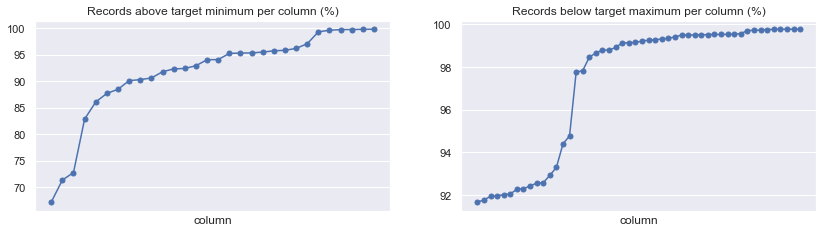

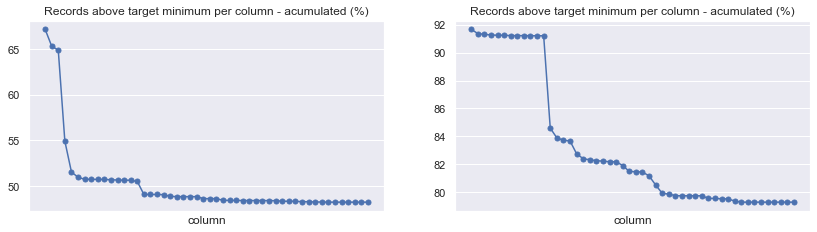

In [12]:
n_cum = 50

fig, ax = plt.subplots(1, 2, figsize=(14, 3.5))
stats.set_index('column')['rows left (%)'].head(30).plot(marker='o', ms=5, xticks=[], title='Records above target minimum per column (%)', ax=ax[0])
stats_max.set_index('column')['rows left (%)'].head(50).plot(marker='o', ms=5, xticks=[], title='Records below target maximum per column (%)', ax=ax[1])

fig, ax = plt.subplots(1, 2, figsize=(14, 3.5))
cum_stats.set_index('column')['rows left cum (%)'].iloc[:n_cum].plot(xticks=[], marker='o', ms=5, title='Records above target minimum per column - acumulated (%)', ax=ax[0])
cum_stats_max.set_index('column')['rows left cum (%)'].iloc[:n_cum].plot(xticks=[], marker='o', ms=5, title='Records above target minimum per column - acumulated (%)', ax=ax[1])
plt.show()

### Filter records

In [13]:
n_filters_min = 4
n_filters_max = 13

min_values = mino_desc.loc['min'].loc[stats['column']]
max_values = mino_desc.loc['max'].loc[stats_max['column']]

# Filter data by positive class minimum values
X_filt = min_max_filter(
    X, min_values, # max_values,
    n_filters=n_filters_min, margin_min=0.0, margin_max=0.0
)

# Filter data by positive class maximum values
X_filt = min_max_filter(
    X_filt, None, max_values,
    n_filters=n_filters_max, margin_min=0.0, margin_max=0.0
)

### Filtered transformed data
X_filt = Xf.loc[X_filt.index]
# X_filt = TimeseriesTransformPipeline(
#     X_filt, interpolate='nearest', fillna='min'
# )

### Filter target variable
Y_filt = Y.loc[X_filt.index]

# groups_filt = groupConsecutiveFlags(ts=Y_filt)
groups_filt = groups.loc[X_filt.index] # Does the same as above

cnts = [
    Y_filt.value_counts().to_frame('Class Count'),
    100 * (Y_filt.value_counts().to_frame('Percent left (%)') / Y.value_counts().to_frame('Percent left (%)')).round(4)
]
display(pd.concat(cnts, 1))


Records: 119904
Records left: 65844
Records left (%): 54.91 %


Records: 65844
Records left: 58492
Records left (%): 88.83 %



,Class Count,Percent left (%)
0.0,57626,48.41
1.0,866,100.00


### Variables:

* X, Xf, Y, groups
* X_filt, Y_filt, groups_filt
* X_eval, Y_eval, groups_eval

---
# Cross validate filtered records

In [14]:
# Main parameters definition
seed = 0

n_splits = 5
train_size = 0.66
test_size = 0.33
train_prct = None
test_prct = 'natural'

# Model definition
model = gbc(n_estimators=100, random_state=seed)

### Base KFold Cross Validation on all samples

In [15]:
splitter = MinorityGroupSplitUndersample(
    n_splits,
    train_size, test_size, # Not used if minority split strategy is GroupKFold
    train_prct, test_prct,
    random_state=seed,
)

cv_base = list(splitter.split(
    Xf, Y, groups,
    strategy='GroupKFold'
)); print_cls_cnt(Y, cv_base[0][0], cv_base[0][1])

,Train set,Test set
Class,,
0.0,95120,23917
1.0,692,174


#### Split evaluation

In [16]:
group_shuffle_scr = pd.DataFrame(cross_validate(
    model, Xf, Y, cv=cv_base,
    scoring=scoring, n_jobs=3,
    verbose=5, error_score='raise'
))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:  6.5min remaining:  9.7min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 10.7min finished


#### Save and reload baseline score

In [40]:
group_shuffle_scr.to_csv('Modelagem de Bolsões/Scores/Baseline_1h_KFold_5.csv', index=True)

group_shuffle_scr = pd.read_csv('Modelagem de Bolsões/Scores/Baseline_1h_KFold_5.csv', index_col=0)

### Internal cross validation - Fit and score inside filtered samples

In [41]:
# splitter = MinorityGroupSplitUndersample(
#     n_splits,
#     train_size, test_size, # Not used if minority split strategy is GroupKFold
#     train_prct, test_prct,
#     random_state=seed,
# )

cv_filt = list(splitter.split(
    X_filt, Y_filt, groups_filt,
    strategy='GroupKFold'
)); print_cls_cnt(Y_filt, cv_filt[0][0], cv_filt[0][1])

,Train set,Test set
Class,,
0.0,46047,11578
1.0,692,174


#### Split evaluation

In [42]:
scr_filt = pd.DataFrame(cross_validate(
    model,
    X_filt, Y_filt,
    cv=cv_filt, scoring=scoring,
    return_train_score=True,
    n_jobs=-1, verbose=5,
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.9min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished


### Filtered train set + True proportion test set

In [43]:
cv_plus = balanced_filtered_test_cv(X, Y, X_filt, cv_filt, seed, test_prct='Y')

c:\Users\luisr\anaconda3\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=0.007274987819015776 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


,Train set,Test set
Class,,
0.0,46047,23917
1.0,692,174


,Train set,Test set
Class,,
0.0,46047,23917
1.0,692,174


### Fit inside filtered records and score for included and excluded samples prediction

In [44]:
scr_out = pd.DataFrame(cross_validate(
    model, Xf, Y, cv=cv_plus,
    scoring=scoring, n_jobs=-1,
    verbose=5, error_score='raise'
))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


### Fill excluded samples prediction

In [47]:
X_index = np.array(range(X.shape[0]))
out_index = X_index[~X.index.isin(X_filt.index)].tolist() # filtered out records index, only contains negative class samples

scrs = []
for i, (t_ind, e_ind) in enumerate(cv_plus):
    co(wait=True); print(f'{i+1}/{len(cv_plus)} splits scored')
    xt, xe, yt, ye = Xf.iloc[t_ind], Xf.iloc[e_ind], Y.iloc[t_ind], Y.iloc[e_ind]
    model.fit(xt, yt)
    yhat = model.predict(xe)
    # Fill prediction of outsider group 
    filt_out = pd.Series(e_ind, dtype='int').isin(out_index).values
    yhat[filt_out] = 0.0  # Fix prediction for data left out of the filter
    scr = pd.DataFrame(cr(ye, yhat, output_dict=True)).T
    scr = pd.concat([scr.loc[['0.0', '1.0', 'macro avg'], 'recall'], scr.loc[['0.0', '1.0', 'macro avg'], 'precision']])
    scr.index = ['recall 0', 'recall 1', 'recall', 'precision 0', 'precision 1',  'precision']
    scrs.append(scr)
scr_fill = pd.concat(scrs, 1).T

5/5 splits scored


---
# Visualize cross validation results

In [51]:
scr_cols = ['test_recall-0', 'test_recall-1', 'test_precision-1']
stats_cols = ['mean', 'std']

### Score statistical description comparison

In [52]:
desc_base = group_shuffle_scr.describe().loc[stats_cols, scr_cols]
desc_filt = scr_filt.describe().loc[['mean', 'min', 'max', 'std'], scr_cols]
desc_out = scr_out.describe().loc[['mean', 'min', 'max', 'std'], scr_cols]
desc_fill = scr_fill.describe().loc[['mean', 'min', 'max', 'std'], ['recall 0', 'recall 1', 'precision 1']]

titles = [
    'Base line - true proportion',
    'Filtered - internal proportion',
    'Filtered - true proportion',
    'Filtered fixed predictions - true proportion'
]

descs = [desc_base, desc_filt, desc_out, desc_fill]

for title, desc in zip(titles, descs):
    print('\n', title, '\n')
    display(pd.concat([desc]))


 Base line - true proportion 



,test_recall-0,test_recall-1,test_precision-1
mean,0.998966,0.412305,0.740284
std,0.000240,0.098266,0.054017



 Filtered - internal proportion 



,test_recall-0,test_recall-1,test_precision-1
mean,0.998682,0.520670,0.855521
min,0.998186,0.427746,0.831461
max,0.999131,0.620690,0.908257
std,0.000357,0.075864,0.032892



 Filtered - true proportion 



,test_recall-0,test_recall-1,test_precision-1
mean,0.999278,0.524125,0.840521
min,0.999117,0.427746,0.778947
max,0.999664,0.632184,0.913978
std,0.000221,0.079195,0.050985



 Filtered fixed predictions - true proportion 



,recall 0,recall 1,precision 1
mean,0.999849,0.524125,0.962803
min,0.999749,0.427746,0.948276
max,0.999916,0.632184,0.973684
std,0.000063,0.079195,0.010633


### Score distribution comparison for baseline vs predicted vs filled excluded samples

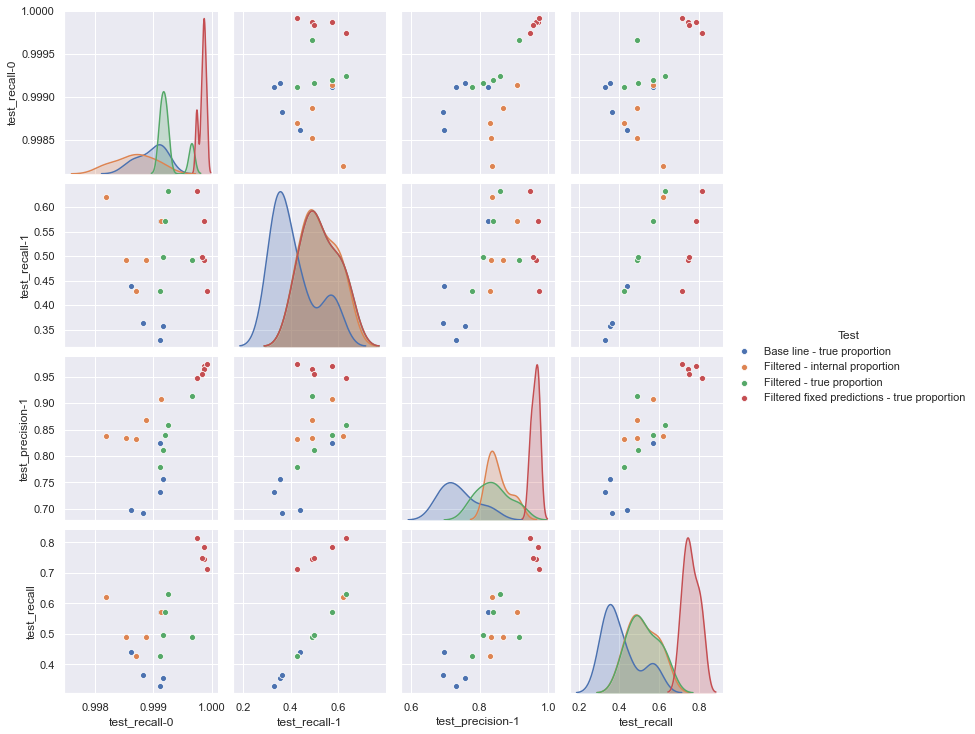

In [53]:
scr_fill_fmt = scr_fill.rename(columns={
    'recall 0': 'test_recall-0',
    'recall 1': 'test_recall-1',
    'precision 1': 'test_precision-1',
    'recall': 'test_recall'
})

scrs = [
    group_shuffle_scr,
    scr_filt,
    scr_out,
    scr_fill_fmt,
]

for i, score in enumerate(scrs):
    scrs[i]['Test'] = titles[i]

tests = pd.concat(scrs, join='inner')[['test_recall-0', 'test_recall-1', 'test_precision-1', 'test_recall', 'Test']]

ax = sns.pairplot(tests, hue='Test')

---
# Final Model Evaluation

### Select best split

In [265]:
selected_split = 0

split = cv_filt[selected_split]

In [266]:
group_shuffle_scr[scr_cols]

,test_recall-0,test_recall-1,test_precision-1
0,0.999164,0.356322,0.756098
1,0.998612,0.439306,0.697248
2,0.999117,0.572254,0.825000
3,0.999117,0.329480,0.730769
4,0.998823,0.364162,0.692308


In [267]:
scr_out.sort_values('test_recall', ascending=False)[['test_recall-1', 'test_precision-1']]

,test_recall-1,test_precision-1
0,0.632184,0.859375
1,0.572254,0.838983
3,0.497110,0.811321
2,0.491329,0.913978
4,0.427746,0.778947


### Optional: Shuffle split

### Filter internal train test samples

In [268]:
t_ind, e_ind = split[0], split[1]
print_cls_cnt(Y_filt, t_ind, e_ind)

xt, xe = X_filt.iloc[t_ind], X_filt.iloc[e_ind]
yt, ye = Y_filt.iloc[t_ind], Y_filt.iloc[e_ind]

,Train set,Test set
Class,,
0.0,46047,11578
1.0,692,174


### Filtered train vs rest sample

In [269]:
train_index = yt.index
test_index = Y.drop(yt.index).index
print_cls_cnt(Y, train_index, test_index)

x_rest, y_rest = Xf.loc[test_index], Y.loc[test_index]

,Train set,Test set
Class,,
0.0,46047,72991
1.0,692,174


### True proportion test sample

In [270]:
from imblearn.under_sampling import RandomUnderSampler

y_cnt = Y.value_counts()
rus = RandomUnderSampler(sampling_strategy=y_cnt[1]/y_cnt[0], random_state=seed)

x_true, y_true = rus.fit_resample(x_rest, y_rest) # resample full test data to true proportion
y_true.index = y_rest.iloc[rus.sample_indices_].index
x_true.index = y_true.index

display(y_true.value_counts().to_frame('Test size - true proportion'))

,Test size - true proportion
0.0,23917
1.0,174


### Sample leaking

In [271]:
train_index.isin(ye.index).sum()

0

In [272]:
train_index.isin(test_index).sum()

0

In [273]:
train_index.isin(x_true.index).sum()

0

In [274]:
train_index.isin(X_eval.index).sum()

0

### Fit model to train data

In [275]:
model = gbc(n_estimators=100, random_state=seed, verbose=1)

model.fit(xt, yt)

      Iter       Train Loss   Remaining Time 
         1           0.0793            1.60m
         2           0.0748            1.50m
         3           0.0711            1.46m
         4           0.0683            1.48m
         5           0.0655            1.52m
         6           0.0625            1.55m
         7           0.0602            1.57m
         8           0.0579            1.59m
         9           0.0563            1.56m
        10           0.0547            1.53m
        20           0.0411            1.31m
        30           0.0346            1.10m
        40           0.0310           55.72s
        50           0.0290           45.94s
        60           0.0272           36.40s
        70           0.0255           27.80s
        80           0.0234           18.79s
        90           0.0219            9.44s
       100           0.0205            0.00s


GradientBoostingClassifier(random_state=0, verbose=1)

### Split internal proportion test set score

In [276]:
yhat = model.predict(xe)
CR = pd.DataFrame(cr(ye, yhat, digits=4, output_dict=True)).T
display(CR.loc[['0.0', '1.0']])

,precision,recall,f1-score,support
0.0,0.994322,0.998186,0.996250,11578.0
1.0,0.837209,0.620690,0.712871,174.0


### True proportion test set score

In [277]:
yhat_true = model.predict(x_true)
CR = pd.DataFrame(cr(y_true, yhat_true, digits=4, output_dict=True)).T
display(CR.loc[['0.0', '1.0']])

,precision,recall,f1-score,support
0.0,0.997246,0.999206,0.998225,23917.0
1.0,0.850394,0.620690,0.717608,174.0


### Filled true proportion set score

In [278]:
filt_out = ~ y_true.index.isin(Y_filt.index)

yhat_fill = yhat_true.copy()
yhat_fill[filt_out] = 0.0  # Fix prediction for data left out of the filter

scr = pd.DataFrame(cr(y_true, yhat_fill, output_dict=True)).T
display(scr.loc[['0.0', '1.0']])

,precision,recall,f1-score,support
0.0,0.997247,0.999749,0.998497,23917.0
1.0,0.947368,0.620690,0.750000,174.0


Obs: Test negative sample size is increased but negative precision increases anyway, against what's expected.

### Validation set score

In [279]:
yhat_eval = model.predict(X_eval)
scr = pd.DataFrame(cr(Y_eval, yhat_eval, output_dict=True)).T
display(scr.loc[['0.0', '1.0']])

,precision,recall,f1-score,support
0.0,0.995420,0.995709,0.995565,17245.0
1.0,0.412698,0.396947,0.404669,131.0


### Filled validation set score

In [280]:
# Filter data by positive class minimum values
X_eval_filt = min_max_filter(
    X_eval, min_values, # max_values,
    n_filters=n_filters_min, margin_min=0.0, margin_max=0.0
)
X_eval_filt = min_max_filter(
    X_eval_filt, None, max_values,
    n_filters=n_filters_max, margin_min=0.0, margin_max=0.0
)

filt_out = ~ Y_eval.index.isin(X_eval_filt.index)

yhat_fill = yhat_eval.copy()
yhat_fill[filt_out] = 0.0  # Fix prediction for data left out of the filter

scr = pd.DataFrame(cr(Y_eval, yhat_fill, output_dict=True)).T
display(scr.loc[['0.0', '1.0']])


Records: 17376
Records left: 11390
Records left (%): 65.55 %


Records: 11390
Records left: 9570
Records left (%): 84.02 %



,precision,recall,f1-score,support
0.0,0.995248,0.995941,0.995594,17245.0
1.0,0.411765,0.374046,0.392000,131.0


---
# Calibration - Risk Threshold Analysis

In [281]:
from sklearn.metrics import precision_recall_curve

yprob = pd.DataFrame(model.predict_proba(x_true), index=y_true.index, columns=['0', '1'])['1']

### Adjust confidence threshold

#### Precision-Recall curve

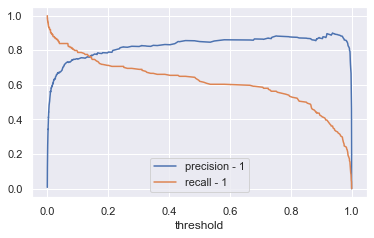


 Classification report for decision threshold of 0.2: 




,precision,recall,f1-score,support
0.0,0.998494,0.998077,0.998285,23917.000000
1.0,0.750000,0.793103,0.770950,174.000000
accuracy,0.996596,0.996596,0.996596,0.996596
macro avg,0.874247,0.895590,0.884618,24091.000000
weighted avg,0.996699,0.996596,0.996643,24091.000000


In [291]:
yhat_fix = (yprob > 0.1).astype('int')

curve = pd.DataFrame(
    precision_recall_curve(y_true, yprob, pos_label=1),
    index=['precision', 'recall', 'threshold']
).T.set_index('threshold').add_suffix(f' - 1')

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
curve.plot(ax=ax); plt.show()
print('\n', 'Classification report for decision threshold of 0.2:', '\n\n')

scr = pd.DataFrame(cr(y_true, yhat_fix, digits=4, output_dict=True)).T
display(scr)

---
# Risk calibration validation test set

In [283]:
yprob_eval = pd.DataFrame(model.predict_proba(X_eval), index=X_eval.index, columns=['0', '1'])['1']

### Adjust confidence threshold

#### Precision-Recall curve

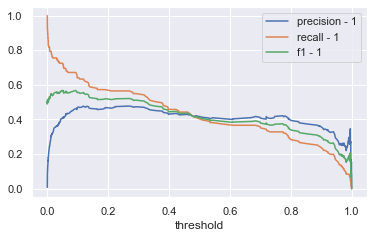


 Classification report for decision threshold of 0.2: 




,precision,recall,f1-score,support
0.0,0.997267,0.994549,0.995906,17245.000000
1.0,0.471910,0.641221,0.543689,131.000000
accuracy,0.991885,0.991885,0.991885,0.991885
macro avg,0.734589,0.817885,0.769798,17376.000000
weighted avg,0.993306,0.991885,0.992497,17376.000000


In [294]:
curve = pd.DataFrame(
    precision_recall_curve(Y_eval, yprob_eval, pos_label=1),
    index=['precision', 'recall', 'threshold']
).T.set_index('threshold').add_suffix(f' - 1')
curve['f1 - 1'] = curve.mean(1)

yhat_fix = (yprob_eval > 0.1).astype('int')

scr = pd.DataFrame(cr(Y_eval, yhat_fix, digits=4, output_dict=True)).T

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
curve.plot(ax=ax); plt.show()

print('\n', 'Classification report for decision threshold of 0.2:', '\n\n')
display(scr)

### Optimal decision threshold

In [286]:
opt_tresh = 0.1

### Calibration curve

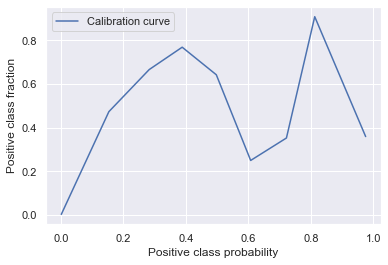

In [287]:
from sklearn.calibration import calibration_curve
cal_curve = calibration_curve(Y_eval, yprob_eval, n_bins=9, strategy='uniform')
calibration = pd.Series(cal_curve[0], index=cal_curve[1]).to_frame('Calibration curve')
ax = calibration.plot()
ax = ax.set(ylabel='Positive class fraction', xlabel='Positive class probability')

### Period scores

#### Accuracy per month and quarter by 

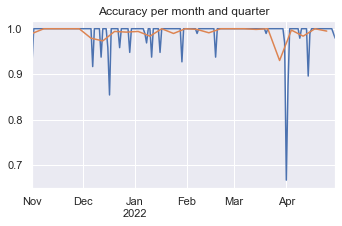

In [288]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.3), tight_layout=True)
(Y_eval == yhat_fix).resample('D').mean().plot(ax=ax)
(Y_eval == yhat_fix).resample('W').mean().plot(ax=ax)
ax.set(title=f'Accuracy per month and quarter'); plt.show()

### Specific period evaluation

In [206]:
def calibrate(prob, threshold=.5):
    if type(prob) is float:
        if prob < threshold:
            return 0.5 * prob / threshold
        else:
            return 0.5 + 0.5 * (prob - threshold) / (1 - threshold)
    if type(threshold) is float:
        threshold = [threshold] * len(prob)
    if type(prob) is np.ndarray:
        return np.array(list(map(calibrate, prob, threshold)))
    elif type(prob) is pd.Series:
        return pd.Series(list(map(calibrate, prob, threshold)), index=prob.index)

In [249]:
pred_cmap = lambda pred, true_value: 'red' if pred!=true_value else ('green' if true_value==1 else (0,0,0,0))

def prediction_probability_plot(yprob, y, threshold=0.5, start=None, end=None, figsize=(12, 6), path=None, ax=None):
    
    if start is None: start = y.index.min()
    if end is None: end = y.index.max()
    
    yhat = (yprob > threshold).astype('int')
    
    prob_msk = (yprob.index > start) & (yprob.index < end)
    msk = (y.index > start) & (y.index < end)

    colors = list(map(pred_cmap, yhat[msk], y[msk]))
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    yprob[prob_msk].plot(ax=ax)
    y[msk].plot(ax=ax, color='orange', lw=1, alpha=.75)
    y[msk][y[msk]==1].plot(ax=ax, ms=5, marker='o', color='orange', lw=0)
    ax.scatter(
        yprob.index[prob_msk], yprob[prob_msk], s=30,
        color=colors
    )
    ax.set(title='Predicted positive probability\n{} - {} threshold: {}'.format(start.date().isoformat(), end.date().isoformat(), round(threshold, 2)))
    if path is not None:
        plt.savefig(path.format(start.date().isoformat(), end.date().isoformat(), round(threshold, 2)))
    return ax    

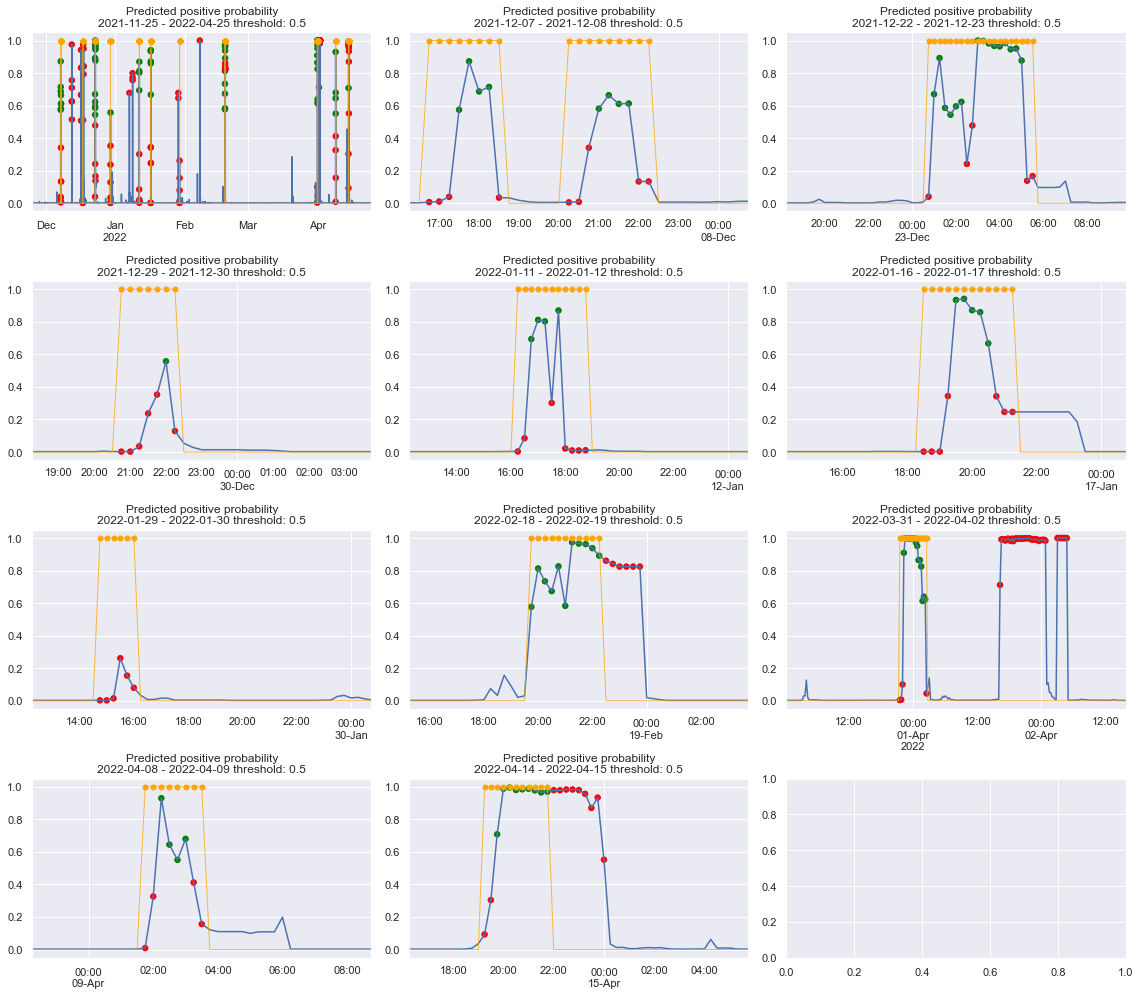

In [320]:
import warnings; warnings.filterwarnings('ignore')
dates = [
    (pd.datetime(2021, 11, 25), pd.datetime(2022, 4, 25)),
    (pd.datetime(2021, 12, 7, 16), pd.datetime(2021, 12, 8, 1)), 
    (pd.datetime(2021, 12, 22, 18), pd.datetime(2021, 12, 23, 10)), 
    (pd.datetime(2021, 12, 29, 18), pd.datetime(2021, 12, 30, 4)), 
    (pd.datetime(2022, 1, 11, 12), pd.datetime(2022, 1, 12, 1)), 
    (pd.datetime(2022, 1, 16, 14), pd.datetime(2022, 1, 17, 1)), 
    (pd.datetime(2022, 1, 29, 12), pd.datetime(2022, 1, 30, 1)), 
    (pd.datetime(2022, 2, 18, 15), pd.datetime(2022, 2, 19, 4)), 
    (pd.datetime(2022, 3, 31, 0), pd.datetime(2022, 4, 2, 16)),
    (pd.datetime(2022, 4, 8, 22), pd.datetime(2022, 4, 9, 9)),
    (pd.datetime(2022, 4, 14, 16), pd.datetime(2022, 4, 15, 6)),
#     (pd.datetime(2022, 4, 5, 16), pd.datetime(2022, 5, 1, 22))
]

yprob_cal = calibrate(yprob_eval, 0.2)
prob_path = 'Modelagem de Bolsões/Results/Probabilidade/prob_plot_{}_{}_{}.png'

# multi_prediction_probability_plot(yprob, ye, threshold, dates, path=None, prob_path=None)

fig, axs = plt.subplots(4, 3, figsize=(16, 14), tight_layout=True); axs = axs.reshape(-1)
for i, date in enumerate(dates[:]):
    start, end = date
    prediction_probability_plot(yprob_cal, Y_eval, 0.5, start, end, path=None, ax=axs[i])
# plt.savefig('Modelagem de Bolsões/Results/probabilidade_catete.png')
plt.show()

# Save model

### Fit choosen model - Optimize max_depth

In [321]:
final_index = X_filt.index
final_test = X.index[X.index.isin(X_filt.index)]
final_model = gbc(n_estimators=100, random_state=0)

In [323]:
final_model.fit(X_filt.loc[final_index], Y_filt.loc[final_index])

GradientBoostingClassifier(random_state=0)

In [ ]:
pd.DataFrame(cr(model.predict()))

### Save finalized model

In [314]:
import pickle

pickle.dump(model, open('ModeloBolsõesCatete.pickle', 'wb'))

### Save model deployment transformation info

#### Transformation steps:
0. Reshape apis response to flat format
1. Drop non-included columns (empty excluded columns)
1. Scale all columns based on 'X' sample min and max values
1. Fill missing values with sample min values

In [311]:
# Save Features description
X_info = data.loc[X.index, X.columns].describe().loc[['min', 'max']].T
# X_info.to_csv('InformaçõesDeployCatete.csv', index=True)

# Save train index
# train_index.to_series(name='Train Index').to_csv('TrainIndexCatete.csv', index=False)

display(X_info.head(), X_info.shape, train_index[:5])

,min,max
acumulado_chuva_1_h - A602,0.0,65.0
pressao_minima - A602,999.3,1030.7
temperatura - A602,11.2,38.9
pressao_maxima - A602,999.4,1031.0
pressao - A602,999.3,1030.9


(217, 2)

DatetimeIndex(['2018-10-10 17:30:00', '2018-10-10 17:45:00',
               '2018-10-10 18:00:00', '2018-10-10 18:15:00',
               '2018-10-10 18:30:00'],
              dtype='datetime64[ns]', freq=None)

---
## Next steps:
1. Check posibility of train_size or threshold optimization on internal split
1. Aggregate observations one hour ahead
1. Different undersampling techniques
1. Pieline for all samples
1. Calibration cv


---
# Critical water bag group - Exploratory Data analysis

In [80]:
bins = np.arange(0, 1.01, 0.01)
bins0 = np.arange(0, 1.01, 0.2)

## Average Mean and Median Difference

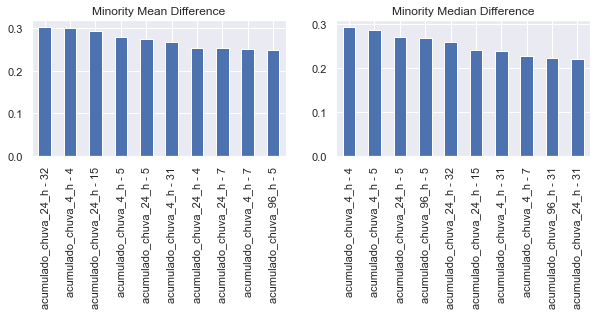

In [81]:
mean_diff = abs(majo.mean() - mino.mean()).sort_values(ascending=False)
median_diff = abs(majo.median() - mino.median()).sort_values(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
mean_diff.head(10).plot.bar(ax=ax[0], title='Minority Mean Difference')
median_diff.head(10).plot.bar(ax=ax[1], title='Minority Median Difference')
plt.show()

### Minority/majority percentiles comparison

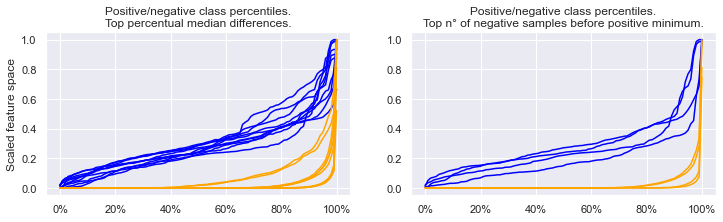

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
mino.loc[:, median_diff.index[:10]].describe(np.arange(0, 1.01, 0.01)).iloc[4:-1].plot(legend=[], color='blue', ax=ax[0])
majo.loc[:, median_diff.index[:10]].describe(np.arange(0, 1.01, 0.01)).iloc[4:-1].plot(legend=[], color='orange', ax=ax[0])

mino.loc[:, stats['column'][:4]].describe(np.arange(0, 1.01, 0.01)).iloc[4:-1].plot(legend=[], color='blue', ax=ax[1])
majo.loc[:, stats['column'][:4]].describe(np.arange(0, 1.01, 0.01)).iloc[4:-1].plot(legend=[], color='orange', ax=ax[1])

ax[0].set(title='Positive/negative class percentiles.\nTop percentual median differences.', ylabel='Scaled feature space')
ax[1].set(title='Positive/negative class percentiles.\nTop n° of negative samples before positive minimum.')
plt.show()

## Incident/no-incident Distributions

#### Minority highest percentual median differences

,Class Count - Y
0.0,122095
1.0,689


,Class Count - Y Sample
0.0,2296
1.0,689


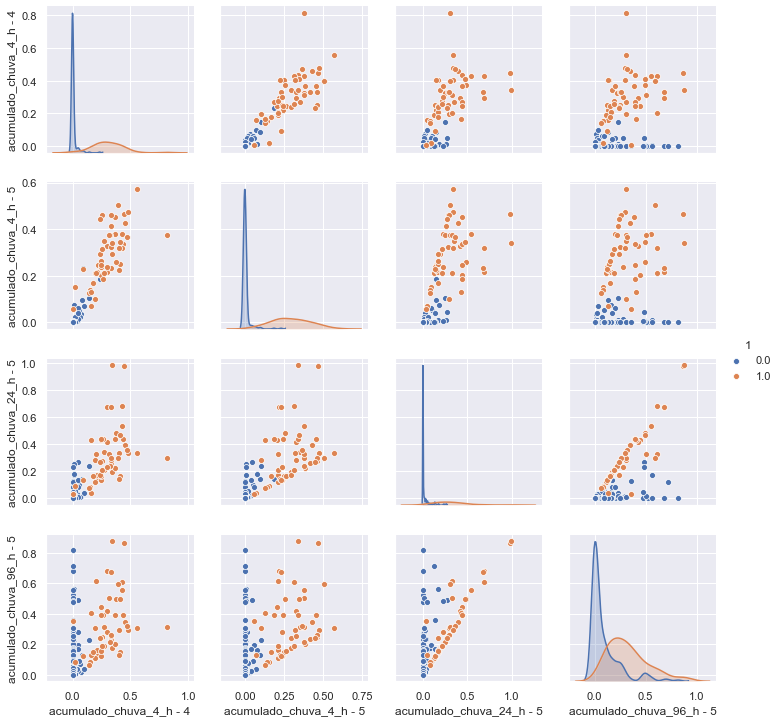

In [83]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=.3, random_state=42)

X_res, Y_res = rus.fit_resample(X, Y)
display(Y.value_counts().to_frame('Class Count - Y'))
display(Y_res.value_counts().to_frame('Class Count - Y Sample'))

ax = sns.pairplot(X_res[median_diff.index[:4]].join(Y_res).sample(250), hue=str(top_grp), kind='scatter', diag_kind='auto')
plt.show()

### Highest minority percentual median difference - After min max filter

,Class Count - Y
0.0,122095
1.0,689


,Class Count - Y Sample
0.0,2296
1.0,689


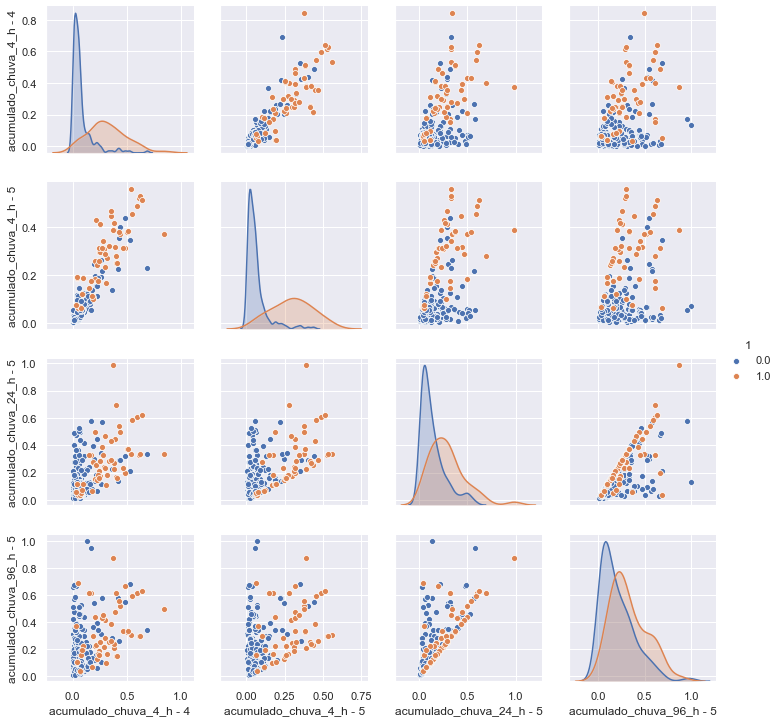

In [84]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=.3, random_state=42)

X_res, Y_res = rus.fit_resample(X_filt, Y_filt)
display(Y.value_counts().to_frame('Class Count - Y'))
display(Y_res.value_counts().to_frame('Class Count - Y Sample'))

ax = sns.pairplot(X_res[median_diff.index[:4]].join(Y_res).sample(250), hue=str(top_grp), kind='scatter', diag_kind='auto')
plt.show()

### Highest number of samples before minority minimum values

,Class Count - Y
0.0,122095
1.0,689


,Class Count - Y Sample
1.0,689
0.0,689


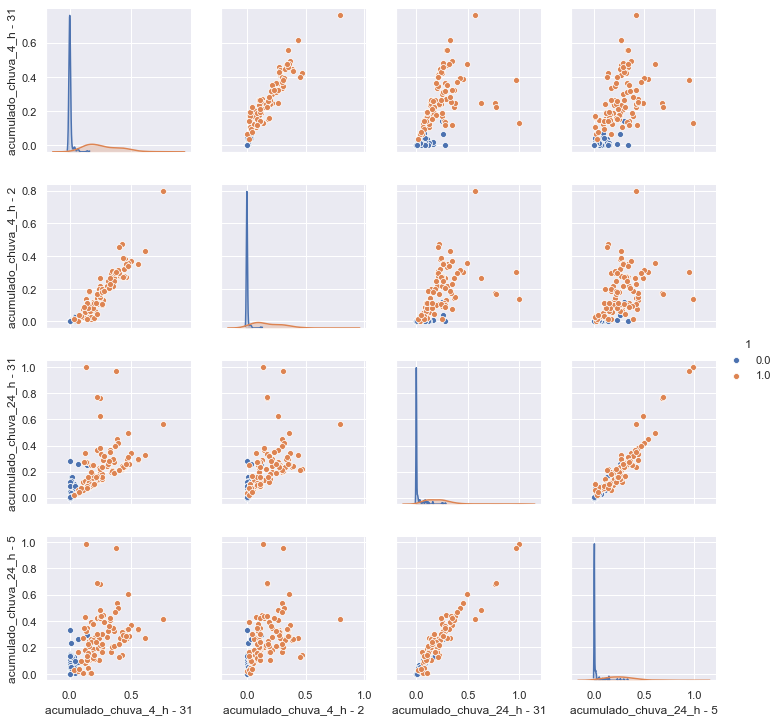

In [85]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=1, random_state=42)

X_res, Y_res = rus.fit_resample(X, Y)
display(Y.value_counts().to_frame('Class Count - Y'))
display(Y_res.value_counts().to_frame('Class Count - Y Sample'))

ax = sns.pairplot(X_res[stats['column'].iloc[:4]].join(Y_res).sample(250), hue=str(top_grp), kind='scatter', diag_kind='auto')
plt.show()

### Highest number of samples before minority minimum values - After min max filter

,Class Count - Y
0.0,122095
1.0,689


,Class Count - Y Sample
1.0,689
0.0,689


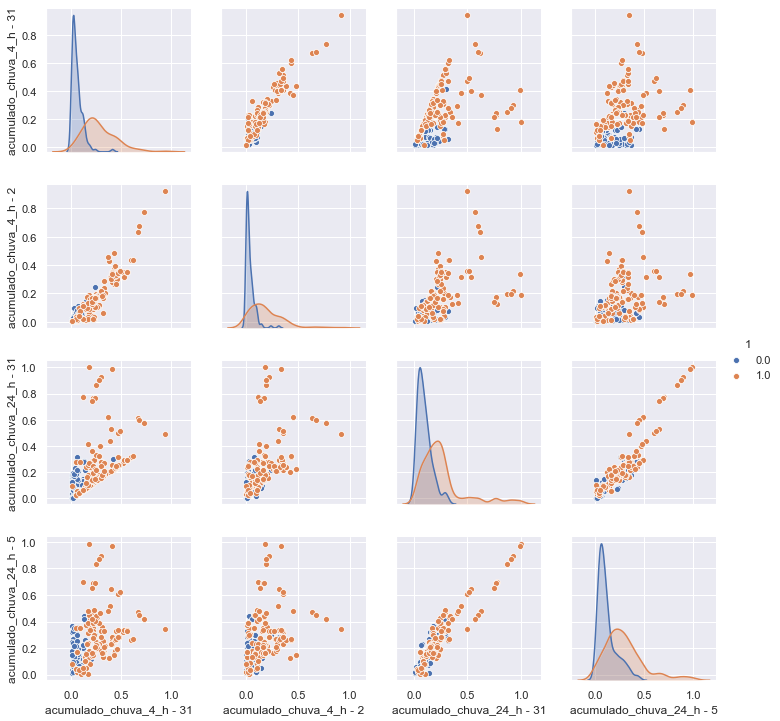

In [86]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=, random_state=42)

X_res, Y_res = rus.fit_resample(X_filt, Y_filt)
display(Y.value_counts().to_frame('Class Count - Y'))
display(Y_res.value_counts().to_frame('Class Count - Y Sample'))

ax = sns.pairplot(X_res[stats['column'].iloc[:4]].join(Y_res).sample(250), hue=str(top_grp), kind='scatter', diag_kind='auto')
plt.show()

### Top median difference feature space

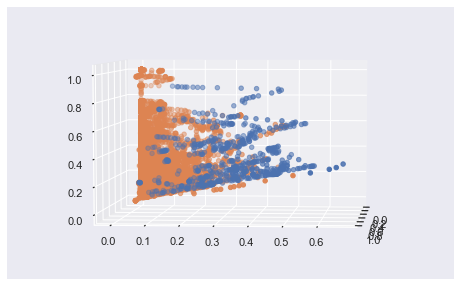

In [92]:
x = median_diff.index[0]
y = median_diff.index[1]
z = median_diff.index[3]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(mino[x], mino[y], mino[z])
ax.scatter(majo[x], majo[y], majo[z])
ax.view_init(5, 5)